In [401]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
%matplotlib inline

In [402]:
args = {'lr':0.0001,
        'train epochs':3000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

In [403]:
df = pd.read_excel('data_3nm.xlsx')

In [404]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [405]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [406]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [407]:
# add noise
X_noisy = add_noise(X, args['noise'])

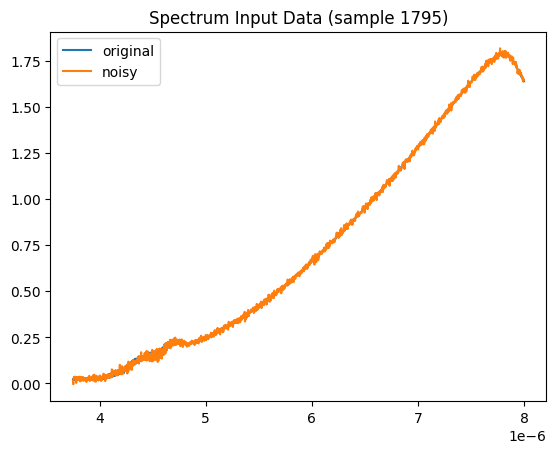

In [408]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [409]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [411]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [412]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin3 = nn.Linear(30, 9)
        self.lin_fin = nn.Linear(9, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin3(x))
        x = self.lin_fin(x)
        return x

In [413]:
criterion = args['train criterion']
model = Net(X_train_tensor.size()[1], y_train_tensor.size()[1])
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

print(model)

Net(
  (lin1): Linear(in_features=1417, out_features=30, bias=True)
  (lin3): Linear(in_features=30, out_features=9, bias=True)
  (lin_fin): Linear(in_features=9, out_features=11, bias=True)
)


In [414]:
best_loss = np.inf
best_epoch = 0
train_losses = []
valid_losses = []

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    valid_pred = model(X_test_tensor)
    valid_loss = criterion(valid_pred, y_test_tensor)
    valid_losses.append(valid_loss.item())

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch = {epoch+1},'.ljust(13) + f' train loss = {loss:.3f},'.ljust(21) + f' valid loss = {valid_loss.item():.3f}')

print(f'\nbest training loss: {best_loss:.3f} in epoch {best_epoch}\n')  

epoch = 300,  train loss = 4.989,  valid loss = 5.131
epoch = 600,  train loss = 4.302,  valid loss = 4.735
epoch = 900,  train loss = 3.758,  valid loss = 4.354
epoch = 1200, train loss = 3.569,  valid loss = 4.154
epoch = 1500, train loss = 3.486,  valid loss = 4.066
epoch = 1800, train loss = 3.458,  valid loss = 4.038
epoch = 2100, train loss = 3.442,  valid loss = 4.022
epoch = 2400, train loss = 3.430,  valid loss = 4.011
epoch = 2700, train loss = 3.418,  valid loss = 4.000
epoch = 3000, train loss = 3.409,  valid loss = 3.992

best training loss: 3.409 in epoch 3000



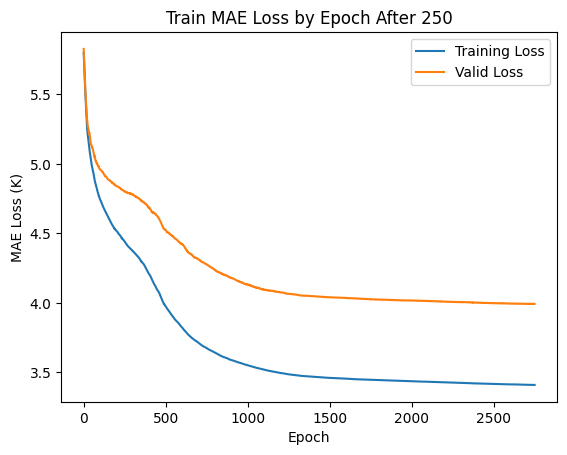

In [415]:
plt.plot(train_losses[250:], label='Training Loss')
plt.plot(valid_losses[250:], label='Valid Loss')

    
plt.title("Train MAE Loss by Epoch After 250")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [416]:
test_criterion = args['test criterion']

print('Test Losses')
with torch.no_grad():
    model.eval()
    pred = model(X_test_tensor)
    loss = test_criterion(pred, y_test_tensor)

    print(f'Overall: {loss.item()}\n')

    pred_layers = []
    for i in range(pred.size(1)):
        column = pred[:, i]
        pred_layers.append(column)

    actual_layers = []
    for i in range(y_test_tensor.size(1)):
        column = y_test_tensor[:, i]
        actual_layers.append(column)

    for i in range(y_test_tensor.size(1)):
        loss = test_criterion(pred_layers[i], actual_layers[i])
        
        print(f'Layer {i+1}: {loss.item()}')



Test Losses
Overall: 3.992311954498291

Layer 1: 4.373980522155762
Layer 2: 7.175948619842529
Layer 3: 3.958622694015503
Layer 4: 3.674593925476074
Layer 5: 4.7502970695495605
Layer 6: 4.231922626495361
Layer 7: 4.47648811340332
Layer 8: 3.306034803390503
Layer 9: 3.5732524394989014
Layer 10: 3.054908275604248
Layer 11: 1.339383602142334


In [417]:
pred_df = pd.DataFrame(pred.numpy())

In [418]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

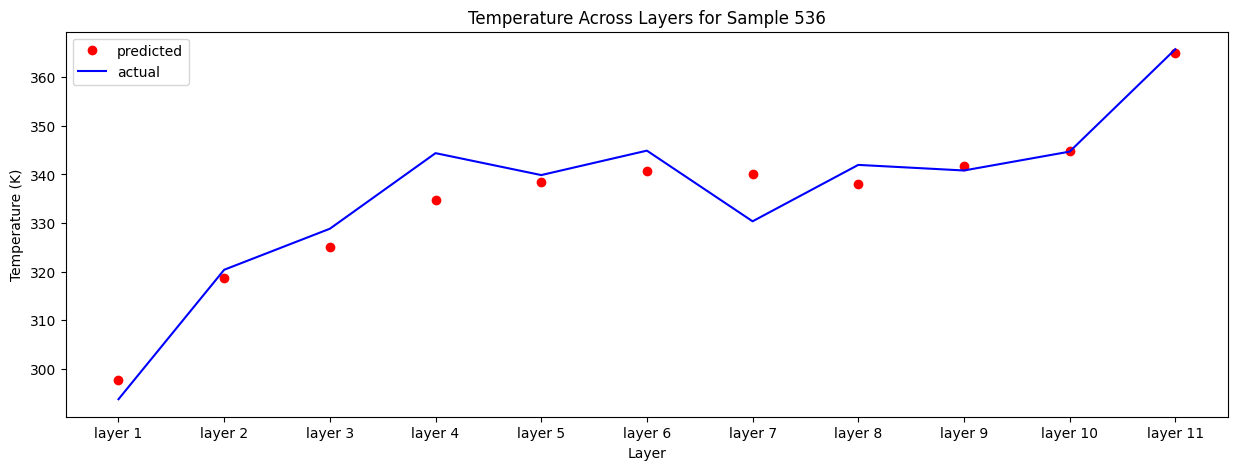

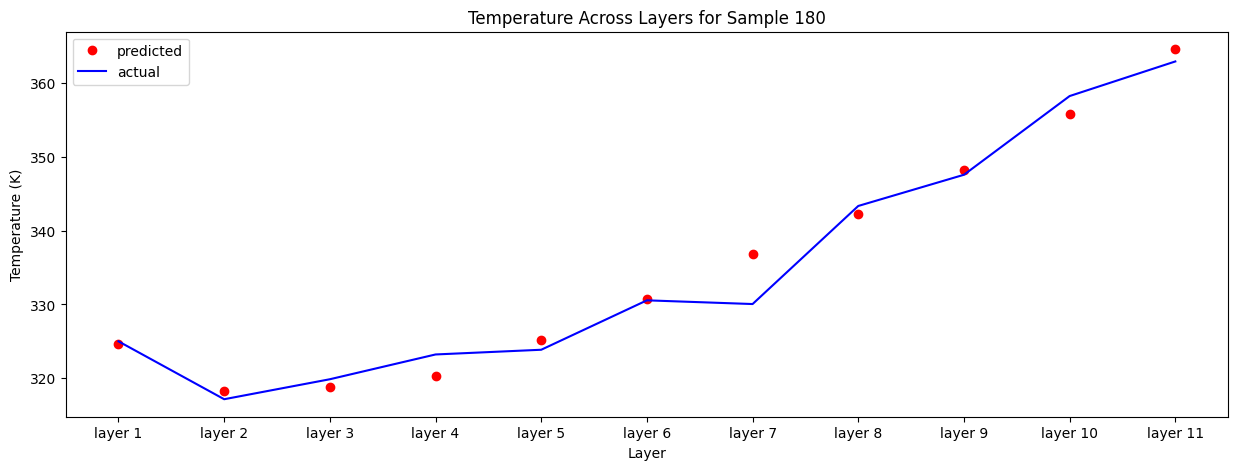

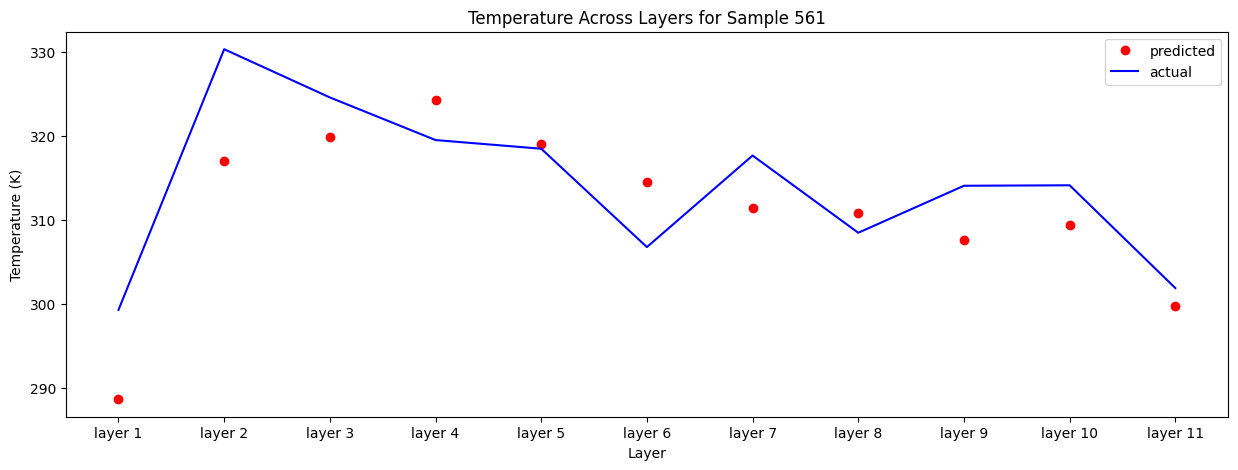

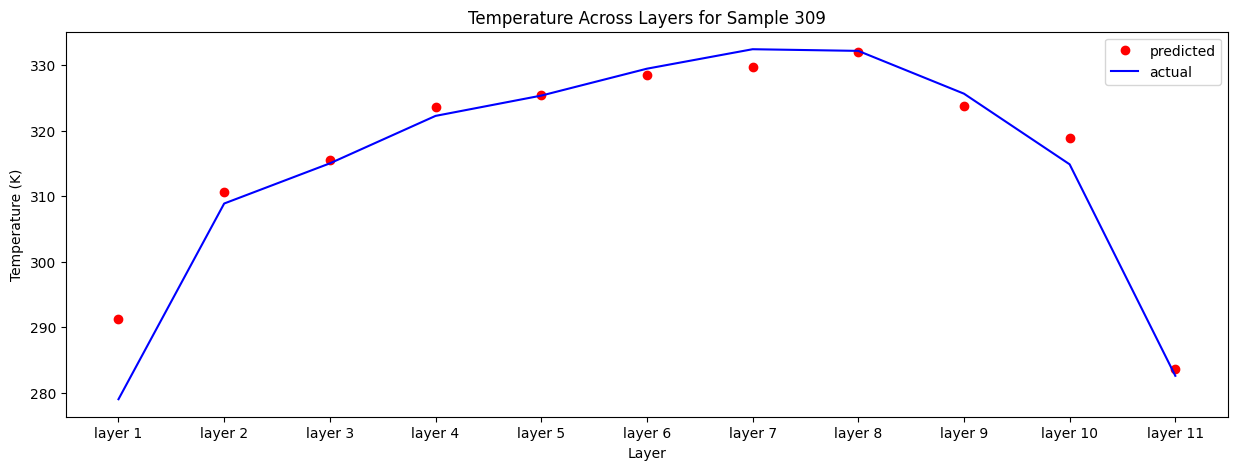

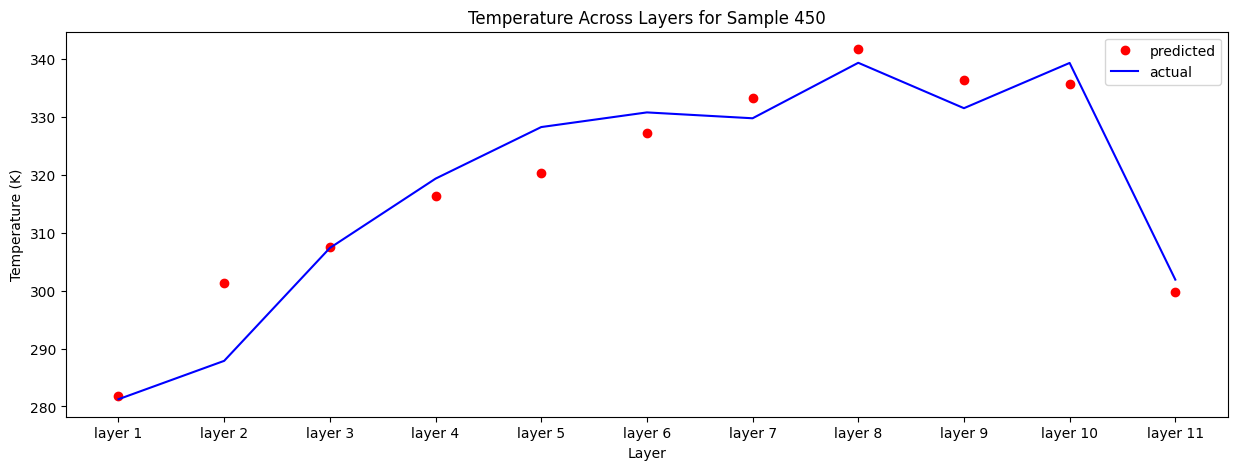

In [419]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    a = y_test.iloc[i,:]
    p = pred_df.iloc[i,:]

    plot_comparison(p, a, i)